In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from scipy.stats import ttest_ind
import math
from scipy.stats import pearsonr, spearmanr
import plotly.graph_objects as go
import plotly.express as px
from sklearn.impute import SimpleImputer, KNNImputer
from tqdm import tqdm_notebook
from venn import venn
from sklearn.decomposition import PCA
import pickle
from sklearn.preprocessing import MinMaxScaler

In [3]:
pd.options.display.max_columns = 50
# mpl.rcParams['font.family'] = 'Avenir'
plt.rc('font', family='Helvetica')
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = (10.0, 7.0)


In [4]:
seed = 42

In [5]:
drug_df = pd.read_csv("../../data/drug/drug_final_processed_eg_id.csv.gz", low_memory=False)

In [6]:
print(drug_df['drug_id'].unique().size)
print(drug_df['drug_name'].unique().size)

819
627


# cutoff

In [9]:
counts = drug_df.groupby(['drug_id']).size()

Text(0, 0.5, 'Number of drugs')

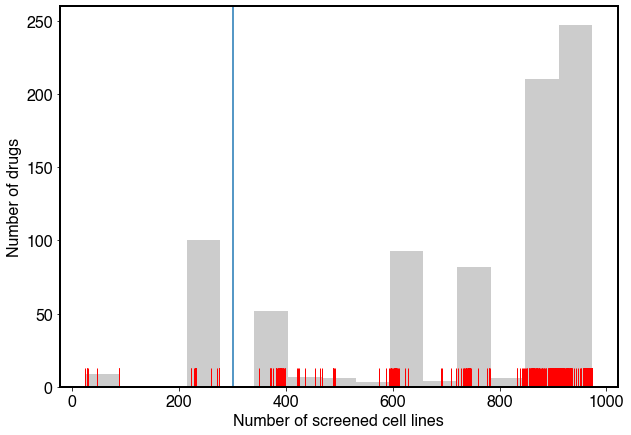

In [7]:
sns.distplot(drug_df.groupby(['drug_id']).size(),
             kde=False,
             hist=True,
             rug=True,
             color='grey',
             rug_kws={'color': 'red'})
plt.plot((300, 300), (0, 260))
plt.ylim(0,260)
plt.xlabel("Number of screened cell lines")
plt.ylabel("Number of drugs")
# plt.savefig("../../plots/drug/Fig4S-A.pdf", dpi=500)

In [30]:
print(drug_df['putative_target'].unique().size)

427


In [29]:
drug_df[drug_df['putative_target']!=drug_df['putative_gene_target']]

,num_replicates,RMSE,drug_id,sample_treatment,putative_target,model_treatment,model_name,msi_status,CHEMBL,cell_line_name,model_synonyms,cancer_type_detail,drug_name,putative_gene_target,use_in_publications,model_type,drug_synonyms,RRID,dataset,ln_IC50,model_id,drug_owner,BROAD_ID,master_cell_id,sample_treatment_details,max_screening_conc,cancer_type,target_pathway,tissue,sample_site,growth_properties,webrelease,COSMIC_ID,AUC,PUBCHEM,IC50_raw,IC50_norm_raw,IC50_norm,sensitive,IC50_norm_scaled
386,1.0,0.262734,3,Unknown,MTORC1,NaN,697,MSS,CHEMBL413,697,Line 697;EU-3,B Acute Lymphoblastic Leukemia,Rapamycin,MTOR,Y,Cell Line,"AY-22989, Sirolimus, WY-090217, Torisel, Rapamune",CVCL_0079,GDSC1,-5.255411,SIDM01076,MGH,ACH-000070,63,NaN,0.1,B-Lymphoblastic Leukemia,PI3K/MTOR signaling,Haematopoietic and Lymphoid,Bone marrow,Suspension,Y,906800,0.468936,5384616,0.005219,0.052192,-2.952826,1,0.435307
387,1.0,0.202144,3,None,MTORC1,NaN,8-MG-BA,MSS,CHEMBL413,8-MG-BA,NaN,Glioblastoma,Rapamycin,MTOR,Y,Cell Line,"AY-22989, Sirolimus, WY-090217, Torisel, Rapamune",CVCL_1052,GDSC1,-2.191715,SIDM00998,MGH,ACH-000137,1207,NaN,0.1,Glioblastoma,PI3K/MTOR signaling,Central Nervous System,Frontal Brain lobe,Adherent,Y,687562,0.898868,5384616,0.111725,1.117249,0.110870,0,0.618394
388,1.0,0.045439,3,Unknown,MTORC1,NaN,A253,MSS,CHEMBL413,A253,NaN,Salivary Gland Squamous Cell Carcinoma,Rapamycin,MTOR,Y,Cell Line,"AY-22989, Sirolimus, WY-090217, Torisel, Rapamune",CVCL_1060,GDSC1,0.302386,SIDM00796,MGH,ACH-000740,2089,NaN,0.1,Head and Neck Carcinoma,PI3K/MTOR signaling,Head and Neck,Submaxillary salivary gland,Adherent,Y,906794,0.985041,5384616,1.353084,13.530836,2.604971,0,0.767441
389,1.0,0.241822,3,Unknown,MTORC1,NaN,A3-KAW,MSS,CHEMBL413,A3-KAW,A3/Kawakami,Diffuse Large B-Cell Lymphoma,Rapamycin,MTOR,Y,Cell Line,"AY-22989, Sirolimus, WY-090217, Torisel, Rapamune",CVCL_1062,GDSC1,-5.939557,SIDM00495,MGH,ACH-000697,1511,NaN,0.1,B-Cell Non-Hodgkin's Lymphoma,PI3K/MTOR signaling,Haematopoietic and Lymphoid,Ascites,Suspension,Y,910935,0.349757,5384616,0.002633,0.026332,-3.636972,1,0.394422
390,1.0,0.220803,3,Unknown,MTORC1,NaN,A4-Fuk,MSS,CHEMBL413,A4-Fuk,A4/Fukuda,B Acute Lymphoblastic Leukemia,Rapamycin,MTOR,Y,Cell Line,"AY-22989, Sirolimus, WY-090217, Torisel, Rapamune",CVCL_1064,GDSC1,-4.601047,SIDM00502,MGH,ACH-000157,186,NaN,0.1,B-Lymphoblastic Leukemia,PI3K/MTOR signaling,Haematopoietic and Lymphoid,Ascites,Suspension,Y,910934,0.574998,5384616,0.010041,0.100413,-2.298462,1,0.474412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548524,3.0,0.075639,2638,Unknown,MCL1,NaN,PSN1,MSS,SCHEMBL19472011,PSN1,NaN,Pancreatic Adenocarcinoma,AZD5991,NaN,Y,Cell Line,NaN,CVCL_1644,GDSC2,2.467330,SIDM00469,GDSC,ACH-000320,560,NaN,10.0,Pancreatic Carcinoma,Apoptosis regulation,Pancreas,Pancreas,Adherent,N,910546,0.842019,NaN,11.790925,1.179093,0.164745,0,0.621613
548525,2.0,0.058714,2638,Unknown,MCL1,NaN,SU8686,MSS,SCHEMBL19472011,SU8686,NaN,Pancreatic Adenocarcinoma,AZD5991,NaN,Y,Cell Line,NaN,CVCL_3881,GDSC2,5.759466,SIDM01188,GDSC,ACH-000114,268,NaN,10.0,Pancreatic Carcinoma,Apoptosis regulation,Pancreas,Liver,Adherent,N,1240218,0.937823,NaN,317.178984,31.717898,3.456881,0,0.818352
548526,2.0,0.072388,2638,Unknown,MCL1,NaN,SUIT-2,MSS,SCHEMBL19472011,SUIT-2,NaN,Pancreatic Ductal Adenocarcinoma,AZD5991,NaN,Y,Cell Line,NaN,CVCL_3172,GDSC2,4.074914,SIDM00371,GDSC,ACH-000652,1749,NaN,10.0,Pancreatic Carcinoma,Apoptosis regulation,Pancreas,Liver,Unknown,N,1240219,0.907596,NaN,58.845428,5.884543,1.772329,0,0.717683
548527,2.0,0.077521,2638,Unknown,MCL1,NaN,SW1990,MSS,SCHEMBL19472011,SW1990,NaN,Pancreatic Adenocarcinoma,AZD5991,NaN,Y,Cell Line,NaN,CVCL_1723,GDSC2,3.757604,SIDM01165,GDSC,ACH-000155,1912,NaN,10.0,Pancreatic Carcinoma,Apoptosis regulation,Pancreas,Spleen,Adherent,N,910907,0.867888,NaN,42.845665,4.284566,1.455019,0,0.698720


# dataset version comparison

In [8]:
raw_df = pd.read_csv("../../data/drug/DrugResponse_PANCANCER_GDSC1_GDSC2_20200605.csv.gz", low_memory=False)

In [12]:
drug_info = raw_df.drop_duplicates(['drug_id', 'dataset'])[['drug_id', 'drug_name', 'dataset']]

In [18]:
data_counts = drug_info.groupby(['drug_id']).size()
two_screen_drugs = data_counts[data_counts>1].index.values
print(two_screen_drugs.shape)

(71,)


In [26]:
two_screen_drugs_df = raw_df[raw_df['drug_id'].isin(two_screen_drugs)][[
    'drug_id','cell_line_name','dataset', 'ln_IC50'
]].reset_index(drop=True)

In [34]:
two_screen_drugs_df_gdsc1 = two_screen_drugs_df[two_screen_drugs_df['dataset']
                                                == 'GDSC1'].drop(['dataset'],
                                                                 axis=1)
two_screen_drugs_df_gdsc2 = two_screen_drugs_df[two_screen_drugs_df['dataset']
                                                == 'GDSC2'].drop(['dataset'],
                                                                 axis=1)

In [36]:
two_screen_drugs_df = pd.merge(two_screen_drugs_df_gdsc1,
                               two_screen_drugs_df_gdsc2,
                               on=['drug_id', 'cell_line_name'], suffixes=['_GDSC1', '_GDSC2'])

In [46]:
pearsonr(two_screen_drugs_df['ln_IC50_GDSC1'].values, two_screen_drugs_df['ln_IC50_GDSC2'].values)

(0.819066922732768, 0.0)

In [43]:
corr = []
for drug_id in two_screen_drugs_df['drug_id'].unique():
    tmp_df = two_screen_drugs_df[two_screen_drugs_df['drug_id']==drug_id]
    corr.append(spearmanr(tmp_df['ln_IC50_GDSC1'].values, tmp_df['ln_IC50_GDSC2'].values)[0])

# two processed comparison

In [8]:
df_old = pd.read_csv("../../data/drug/drug_final_processed.csv.gz", low_memory=False)
df_eg_id = pd.read_csv("../../data/drug/drug_final_processed_eg_id.csv.gz", low_memory=False)

In [10]:
df_old[df_old['drug_id']==1029]

,num_replicates,RMSE,drug_id,sample_treatment,putative_target,model_treatment,model_name,msi_status,CHEMBL,cell_line_name,model_synonyms,cancer_type_detail,drug_name,putative_gene_target,use_in_publications,model_type,drug_synonyms,RRID,dataset,ln_IC50,model_id,drug_owner,BROAD_ID,master_cell_id,sample_treatment_details,max_screening_conc,cancer_type,target_pathway,tissue,sample_site,growth_properties,webrelease,COSMIC_ID,AUC,PUBCHEM,IC50_raw,IC50_norm_raw,IC50_norm,sensitive,IC50_norm_scaled
199666,1.0,0.032754,1029,Unknown,"VEGFR, RET, KIT, PDGFR",NaN,201T,MSS,CHEMBL572881,201T,NaN,Lung Adenocarcinoma,Motesanib,FLT1;KIT;PDGFRA;PDGFRB;RET,Y,Cell Line,"AMG-706, AMG 706, AMG706",CVCL_X481,GDSC2,6.044100,SIDM00055,GDSC,ACH-002089,220,NaN,10.0,Non-Small Cell Lung Carcinoma,RTK signaling,Lung,Unknown,Unknown,Y,1287381,0.983040,11667893,421.618096,42.161810,3.741515,0,0.835361
199667,1.0,0.038535,1029,Unknown,"VEGFR, RET, KIT, PDGFR",NaN,22RV1,MSI,CHEMBL572881,22RV1,CWR22-Rv1;CWR22-R1,Prostate Carcinoma,Motesanib,FLT1;KIT;PDGFRA;PDGFRB;RET,Y,Cell Line,"AMG-706, AMG 706, AMG706",CVCL_1045,GDSC2,6.787820,SIDM00499,GDSC,ACH-000956,1027,NaN,10.0,Prostate Carcinoma,RTK signaling,Prostate,Prostate,Adherent,Y,924100,0.976605,11667893,886.978219,88.697822,4.485235,0,0.879806
199668,1.0,0.140381,1029,Unknown,"VEGFR, RET, KIT, PDGFR",NaN,23132-87,MSI,CHEMBL572881,23132-87,St 23132,Gastric Adenocarcinoma,Motesanib,FLT1;KIT;PDGFRA;PDGFRB;RET,Y,Cell Line,"AMG-706, AMG 706, AMG706",CVCL_1046,GDSC1,1.739096,SIDM00980,GDSC,ACH-000948,558,NaN,2.0,Gastric Carcinoma,RTK signaling,Stomach,Unknown,Adherent,Y,910924,0.947278,11667893,5.692196,2.846098,1.045949,0,0.674274
199669,1.0,0.103137,1029,None,"VEGFR, RET, KIT, PDGFR",NaN,42-MG-BA,MSS,CHEMBL572881,42-MG-BA,NaN,Glioblastoma,Motesanib,FLT1;KIT;PDGFRA;PDGFRB;RET,Y,Cell Line,"AMG-706, AMG 706, AMG706",CVCL_1798,GDSC1,0.991336,SIDM00982,GDSC,ACH-000323,1465,NaN,2.0,Glioblastoma,RTK signaling,Central Nervous System,Temporal Lobe,Adherent,Y,687561,0.897113,11667893,2.694833,1.347417,0.298189,0,0.629588
199670,1.0,0.025396,1029,Unknown,"VEGFR, RET, KIT, PDGFR",NaN,451Lu,MSS,CHEMBL572881,451Lu,WM 451-Lu;WC00059;LU451;EST81,Melanoma,Motesanib,FLT1;KIT;PDGFRA;PDGFRB;RET,Y,Cell Line,"AMG-706, AMG 706, AMG706",CVCL_6357,GDSC2,6.115670,SIDM01240,GDSC,ACH-001002,577,NaN,10.0,Melanoma,RTK signaling,Skin,Unknown,Adherent,Y,1287706,0.980762,11667893,452.899327,45.289933,3.813085,0,0.839638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200628,1.0,0.030447,1029,Unknown,"VEGFR, RET, KIT, PDGFR",NaN,YT,MSS,CHEMBL572881,YT,NaN,Natural Killer Cell Lymphoblastic Leukemia Lym...,Motesanib,FLT1;KIT;PDGFRA;PDGFRB;RET,Y,Cell Line,"AMG-706, AMG 706, AMG706",CVCL_1797,GDSC2,4.787886,SIDM00410,GDSC,ACH-002317,1521,NaN,10.0,Other Blood Carcinomas,RTK signaling,Haematopoietic and Lymphoid,Pericardial fluid,Suspension,Y,946358,0.991825,11667893,120.047293,12.004729,2.485301,0,0.760290
200629,1.0,0.048707,1029,Unknown,"VEGFR, RET, KIT, PDGFR",NaN,ZR-75-30,MSS,CHEMBL572881,ZR-75-30,NaN,Invasive Ductal Carcinoma not Otherwise Specified,Motesanib,FLT1;KIT;PDGFRA;PDGFRB;RET,Y,Cell Line,"AMG-706, AMG 706, AMG706",CVCL_1661,GDSC2,7.931715,SIDM00971,GDSC,ACH-000828,429,NaN,10.0,Breast Carcinoma,RTK signaling,Breast,Ascites,Adherent,Y,909907,0.973512,11667893,2784.197904,278.419790,5.629130,0,0.948166
200630,1.0,0.148615,1029,Unknown,"VEGFR, RET, KIT, PDGFR",NaN,huH-1,MSS,CHEMBL572881,huH-1,NaN,Hepatocellular Carcinoma,Motesanib,FLT1;KIT;PDGFRA;PDGFRB;RET,Y,Cell Line,"AMG-706, AMG 706, AMG706",CVCL_2956,GDSC1,1.908649,SIDM00586,GDSC,ACH-000475,1855,NaN,2.0,Hepatocellular Carcinoma,RTK signaling,Liver,Unknown,Unknown,Y,1298146,0.935197,11667893,6.743970,3.371985,1.215502,0,0.684407
200631,1.0,0.033412,1029,Unknown,"VEGFR, RET, KIT, PDGFR",NaN,no-10,MSS,CHEMBL572881,no-10,Onda 10;Case 6,Glioblastoma,Motesanib,FLT1;KIT;PDGFRA;

In [16]:
df_eg_id[df_eg_id['drug_id'].str.startswith('1029;Motesanib;GDSC1')].sort_values(by='cell_line_name')

,num_replicates,RMSE,drug_id,sample_treatment,putative_target,model_treatment,model_name,msi_status,CHEMBL,cell_line_name,model_synonyms,cancer_type_detail,drug_name,putative_gene_target,use_in_publications,model_type,drug_synonyms,RRID,dataset,ln_IC50,model_id,drug_owner,BROAD_ID,master_cell_id,sample_treatment_details,max_screening_conc,cancer_type,target_pathway,tissue,sample_site,growth_properties,webrelease,COSMIC_ID,AUC,PUBCHEM,IC50_raw,IC50_norm_raw,IC50_norm,sensitive,IC50_norm_scaled
265033,1.0,0.035525,1029;Motesanib;GDSC1,Unknown,"VEGFR, RET, KIT, PDGFR",NaN,201T,MSS,CHEMBL572881,201T,NaN,Lung Adenocarcinoma,Motesanib,FLT1;KIT;PDGFRA;PDGFRB;RET,Y,Cell Line,"AMG-706, AMG 706, AMG706",CVCL_X481,GDSC1,2.902010,SIDM00055,GDSC,ACH-002089,220,NaN,2.0,Non-Small Cell Lung Carcinoma,RTK signaling,Lung,Unknown,Unknown,Y,1287381,0.967714,11667893,18.210707,9.105353,2.208863,0,0.743770
210198,1.0,0.080248,1029;Motesanib;GDSC1,Unknown,"VEGFR, RET, KIT, PDGFR",NaN,22RV1,MSI,CHEMBL572881,22RV1,CWR22-Rv1;CWR22-R1,Prostate Carcinoma,Motesanib,FLT1;KIT;PDGFRA;PDGFRB;RET,Y,Cell Line,"AMG-706, AMG 706, AMG706",CVCL_1045,GDSC1,3.119341,SIDM00499,GDSC,ACH-000956,1027,NaN,2.0,Prostate Carcinoma,RTK signaling,Prostate,Prostate,Adherent,Y,924100,0.974817,11667893,22.631470,11.315735,2.426194,0,0.756758
203737,1.0,0.140381,1029;Motesanib;GDSC1,Unknown,"VEGFR, RET, KIT, PDGFR",NaN,23132-87,MSI,CHEMBL572881,23132-87,St 23132,Gastric Adenocarcinoma,Motesanib,FLT1;KIT;PDGFRA;PDGFRB;RET,Y,Cell Line,"AMG-706, AMG 706, AMG706",CVCL_1046,GDSC1,1.739096,SIDM00980,GDSC,ACH-000948,558,NaN,2.0,Gastric Carcinoma,RTK signaling,Stomach,Unknown,Adherent,Y,910924,0.947278,11667893,5.692196,2.846098,1.045949,0,0.674274
19550,1.0,0.103137,1029;Motesanib;GDSC1,None,"VEGFR, RET, KIT, PDGFR",NaN,42-MG-BA,MSS,CHEMBL572881,42-MG-BA,NaN,Glioblastoma,Motesanib,FLT1;KIT;PDGFRA;PDGFRB;RET,Y,Cell Line,"AMG-706, AMG 706, AMG706",CVCL_1798,GDSC1,0.991336,SIDM00982,GDSC,ACH-000323,1465,NaN,2.0,Glioblastoma,RTK signaling,Central Nervous System,Temporal Lobe,Adherent,Y,687561,0.897113,11667893,2.694833,1.347417,0.298189,0,0.629588
265262,2.0,0.088786,1029;Motesanib;GDSC1,Unknown,"VEGFR, RET, KIT, PDGFR",NaN,451Lu,MSS,CHEMBL572881,451Lu,WM 451-Lu;WC00059;LU451;EST81,Melanoma,Motesanib,FLT1;KIT;PDGFRA;PDGFRB;RET,Y,Cell Line,"AMG-706, AMG 706, AMG706",CVCL_6357,GDSC1,1.867313,SIDM01240,GDSC,ACH-001002,577,NaN,2.0,Melanoma,RTK signaling,Skin,Unknown,Adherent,Y,1287706,0.948495,11667893,6.470885,3.235443,1.174166,0,0.681936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222820,2.0,0.063684,1029;Motesanib;GDSC1,Unknown,"VEGFR, RET, KIT, PDGFR",NaN,YT,MSS,CHEMBL572881,YT,NaN,Natural Killer Cell Lymphoblastic Leukemia Lym...,Motesanib,FLT1;KIT;PDGFRA;PDGFRB;RET,Y,Cell Line,"AMG-706, AMG 706, AMG706",CVCL_1797,GDSC1,2.370968,SIDM00410,GDSC,ACH-002317,1521,NaN,2.0,Other Blood Carcinomas,RTK signaling,Haematopoietic and Lymphoid,Pericardial fluid,Suspension,Y,946358,0.981604,11667893,10.707751,5.353876,1.677821,0,0.712035
184748,2.0,0.119015,1029;Motesanib;GDSC1,Unknown,"VEGFR, RET, KIT, PDGFR",NaN,ZR-75-30,MSS,CHEMBL572881,ZR-75-30,NaN,Invasive Ductal Carcinoma not Otherwise Specified,Motesanib,FLT1;KIT;PDGFRA;PDGFRB;RET,Y,Cell Line,"AMG-706, AMG 706, AMG706",CVCL_1661,GDSC1,3.294828,SIDM00971,GDSC,ACH-000828,429,NaN,2.0,Breast Carcinoma,RTK signaling,Breast,Ascites,Adherent,Y,909907,0.948890,11667893,26.972772,13.486386,2.601681,0,0.767245
276121,1.0,0.148615,1029;Motesanib;GDSC1,Unknown,"VEGFR, RET, KIT, PDGFR",NaN,huH-1,MSS,CHEMBL572881,huH-1,NaN,Hepatocellular Carcinoma,Motesanib,FLT1;KIT;PDGFRA;PDGFRB;RET,Y,Cell Line,"AMG-706, AMG 706, AMG706",CVCL_2956,GDSC1,1.908649,SIDM00586,GDSC,ACH-000475,1855,NaN,2.0,Hepatocellular Carcinoma,RTK signaling,Liver,Unknown,Unknown,Y,1298146,0.935197,11667893,6.743970,3.371985,1.215502,0,0.684407
149942,1.0,0.067553,1029;Motesanib